In [283]:
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the dataset
file_path = 'dat.csv'  # Replace with actual path if different
ehr_data = pd.read_csv(file_path)

Using device: cuda


# Simple data cleaning

In [284]:
# Step 1: Data Cleaning
# Drop non-numerical columns
numeric_data = ehr_data.select_dtypes(include=['number'])

# Drop rows with excessive missing values (e.g., more than 50% missing)
cleaned_data = numeric_data.dropna(thresh=len(numeric_data.columns) * 0.5)

# Fill remaining missing values with the mean of each column
cleaned_data = cleaned_data.fillna(cleaned_data.mean())

# Remove duplicate rows, if any
cleaned_data = cleaned_data.drop_duplicates()

# Display the cleaned data head for verification
print("Cleaned Data Sample:")
print(cleaned_data.head())

Cleaned Data Sample:
   Unnamed: 0  inpatient.number  visit.times  body.temperature  pulse  \
0           1            857781            1              36.7     87   
1           2            743087            1              36.8     95   
2           3            866418            2              36.5     98   
3           4            775928            1              36.0     73   
4           5            810128            1              35.0     88   

   respiration  systolic.blood.pressure  diastolic.blood.pressure        map  \
0           19                      102                        64  76.666667   
1           18                      150                        70  96.666667   
2           18                      102                        67  78.666667   
3           19                      110                        74  86.000000   
4           19                      134                        62  86.000000   

   weight  ...  carboxyhemoglobin  body.temperature.blood.g

In [285]:
cleaned_data = cleaned_data.drop(columns=['Unnamed: 0'])

In [286]:
# Step to remove columns with only NaN values
cleaned_data = cleaned_data.dropna(axis=1, how='all')

# Re-check the cleaned data after removing all-NaN columns
print(f"Shape after removing all-NaN columns: {cleaned_data.shape}")

Shape after removing all-NaN columns: (1998, 150)


# Converting data to a tensor

In [287]:
# Convert DataFrame to a PyTorch tensor
ehr_tensor = torch.tensor(cleaned_data.values, dtype=torch.float32).to(device)

# Print tensor shape to confirm
print(f"EHR tensor shape: {ehr_tensor.shape}")

EHR tensor shape: torch.Size([1998, 150])


# Normalizing data

In [288]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the cleaned data
normalized_data = scaler.fit_transform(cleaned_data)

# Convert the normalized data to a PyTorch tensor and move it to the device
ehr_tensor_normalized = torch.tensor(normalized_data, dtype=torch.float32).to(device)

# Print the shape and a sample of the normalized tensor to confirm
print(f"Normalized EHR tensor shape: {ehr_tensor_normalized.shape}")
print("Sample of the normalized tensor:")
print(ehr_tensor_normalized[:5])

Normalized EHR tensor shape: torch.Size([1998, 150])
Sample of the normalized tensor:
tensor([[7.3888e-01, 0.0000e+00, 2.4286e-01, 4.3939e-01, 5.2778e-01, 4.0476e-01,
         4.3836e-01, 4.2279e-01, 4.3478e-01, 8.7162e-01, 4.6006e-02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 3.3333e-01, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.5190e-01, 0.0000e+00, 5.9305e-01, 6.0193e-01, 1.1815e-02,
         9.9004e-03, 5.7923e-02, 4.3006e-01, 4.0107e-01, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 8.3095e-02, 5.5089e-02,
         0.0000e+00, 5.5099e-02, 8.6236e-02, 2.4904e-01, 4.6251e-01, 1.9951e-01,
         1.0750e-01, 2.4960e-01, 3.0970e-01, 3.4052e-01, 5.2202e-01, 1.7680e-01,
         2.7397e-01, 4.7051e-01, 5.7339e-01, 2.1634e-01, 5.5219e-01, 7.7477e-01,
         6.3636e-01, 9.

# Train - validation - test split

In [289]:
from sklearn.model_selection import train_test_split

# 80% training, 10% validation, 10% testing

# Split the data into 80% training and 20% temporary (for further splitting)
train_data, temp_data = train_test_split(ehr_tensor_normalized, test_size=0.2, random_state=42)

In [290]:
# Split the temporary data into 50% validation and 50% test (resulting in 10% each overall)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Print the shapes of the resulting datasets
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

Training data shape: torch.Size([1598, 150])
Validation data shape: torch.Size([200, 150])
Test data shape: torch.Size([200, 150])


# Building the transformer architecture

In [291]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### Positional encoding

In [292]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-torch.log(torch.tensor(10000.0)) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1), :].to(x.device)

## The transformer model

In [293]:
class EHRImputationTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout=0.1):
        super(EHRImputationTransformer, self).__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True),
            num_layers=num_encoder_layers
        )
        self.output_layer = nn.Linear(d_model, input_dim)

    def forward(self, x):
        
        assert x.size(2) == self.input_embedding.in_features, "Input feature size mismatch"
        
        x = self.input_embedding(x)
        x = self.positional_encoding(x)
        
        # Pass through transformer encoder
        x = self.transformer_encoder(x)
        
        # Output layer for final prediction
        x = self.output_layer(x)
        return x

### Hyperparameters

In [294]:
input_dim = ehr_tensor_normalized.shape[1]  # Number of features
d_model = 128    # Size of the embedding
nhead = 8        # Number of attention heads
num_encoder_layers = 4  # Number of encoder layers
dim_feedforward = 256   # Size of the feedforward network
dropout = 0.1           # Dropout rate

#### The model

In [295]:
model = EHRImputationTransformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout).to(device)

# Print model summary
print(model)

EHRImputationTransformer(
  (input_embedding): Linear(in_features=150, out_features=128, bias=True)
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=128, out_features=150, bias=True)
)


In [296]:
train_data.shape

torch.Size([1598, 150])

# Optimizer and loss function creation

In [297]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # Mean Squared Error Loss for continuous data

## Training loop setup

In [298]:
def train_model(model, train_data, val_data, num_epochs=50):
    model.train()  # Set model to training mode
    
    # Reshape the input data to have a batch dimension and set sequence length
    # Assuming each sample in train_data is an independent sequence with length 1 for simplicity
    train_data = train_data.unsqueeze(1)  # Shape: [batch_size, sequence_length=1, num_features]
    val_data = val_data.unsqueeze(1)      # Shape: [batch_size, sequence_length=1, num_features]

    for epoch in range(num_epochs):
        # Zero the gradients for each batch
        optimizer.zero_grad()

        # Forward pass
        outputs = model(train_data)

        # Calculate loss (using only non-masked data for training)
        loss = criterion(outputs, train_data)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Print loss every 10 epochs for monitoring
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
        
        # Validation step (optional for monitoring)
        if (epoch + 1) % 10 == 0:
            model.eval()  # Set model to evaluation mode
            with torch.no_grad():
                val_outputs = model(val_data)
                val_loss = criterion(val_outputs, val_data)
            print(f'Validation Loss after epoch {epoch + 1}: {val_loss.item():.4f}')
            model.train()  # Set model back to training mode

#### Running the training loop

In [299]:
train_model(model, train_data, val_data, num_epochs=50)

Epoch [10/50], Loss: 0.0458
Validation Loss after epoch 10: 0.0320
Epoch [20/50], Loss: 0.0373
Validation Loss after epoch 20: 0.0240
Epoch [30/50], Loss: 0.0313
Validation Loss after epoch 30: 0.0194
Epoch [40/50], Loss: 0.0286
Validation Loss after epoch 40: 0.0182
Epoch [50/50], Loss: 0.0269
Validation Loss after epoch 50: 0.0182


# Model Evaluation

In [300]:
import numpy as np
import matplotlib.pyplot as plt

model.eval()

EHRImputationTransformer(
  (input_embedding): Linear(in_features=150, out_features=128, bias=True)
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=128, out_features=150, bias=True)
)

In [304]:
# Ensure validation and test data have the correct shape before forward pass
if len(val_data.shape) == 2:
    val_data = val_data.unsqueeze(1)  # Add a sequence length dimension (shape: [batch_size, 1, num_features])
if len(test_data.shape) == 2:
    test_data = test_data.unsqueeze(1)  # Add a sequence length dimension (shape: [batch_size, 1, num_features])

# Forward pass for validation and test data
with torch.no_grad():
    val_outputs = model(val_data)
    test_outputs = model(test_data)

#### Calculate RMSE

In [305]:
def calculate_rmse(predicted, actual):
    return np.sqrt(((predicted - actual) ** 2).mean())

val_outputs_np = val_outputs.cpu().numpy()
val_data_np = val_data.cpu().numpy()

test_outputs_np = test_outputs.cpu().numpy()
test_data_np = test_data.unsqueeze(0).cpu().numpy()

# Calculate RMSE
val_rmse = calculate_rmse(val_outputs_np, val_data_np)
test_rmse = calculate_rmse(test_outputs_np, test_data_np)

In [306]:
print(f'Validation RMSE: {val_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Validation RMSE: 0.1349
Test RMSE: 0.1317


# Creating synthetic missingnes (MCAR)

In [308]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [312]:
missingness_prob = 0.1  # Set 10% of data to be missing
test_data_with_missing = test_data.clone()

mask = torch.rand(test_data_with_missing.shape).to(device) < missingness_prob
test_data_with_missing[mask] = float('nan')

input_for_model = test_data_with_missing.clone()
input_for_model[mask] = 0

In [313]:
with torch.no_grad():
    imputed_data = model(input_for_model)

In [316]:
imputed_data

tensor([[[0.4250, 0.0193, 0.2412,  ..., 0.5625, 1.0073, 0.0640]],

        [[0.4235, 0.0284, 0.2483,  ..., 0.5521, 1.0192, 0.0733]],

        [[0.4191, 0.0301, 0.2357,  ..., 0.5598, 1.0032, 0.0475]],

        ...,

        [[0.4135, 0.0246, 0.2386,  ..., 0.5588, 1.0116, 0.0614]],

        [[0.4175, 0.0232, 0.2414,  ..., 0.5609, 1.0110, 0.0579]],

        [[0.4272, 0.0252, 0.2443,  ..., 0.5595, 1.0091, 0.0692]]],
       device='cuda:0')

In [317]:
imputed_data = imputed_data.cpu().numpy()
test_data_np = test_data.cpu().numpy()  # Original test data for comparison
imputed_data[~mask.cpu().numpy()] = test_data_np[~mask.cpu().numpy()]  # Replace non-missing values with original data

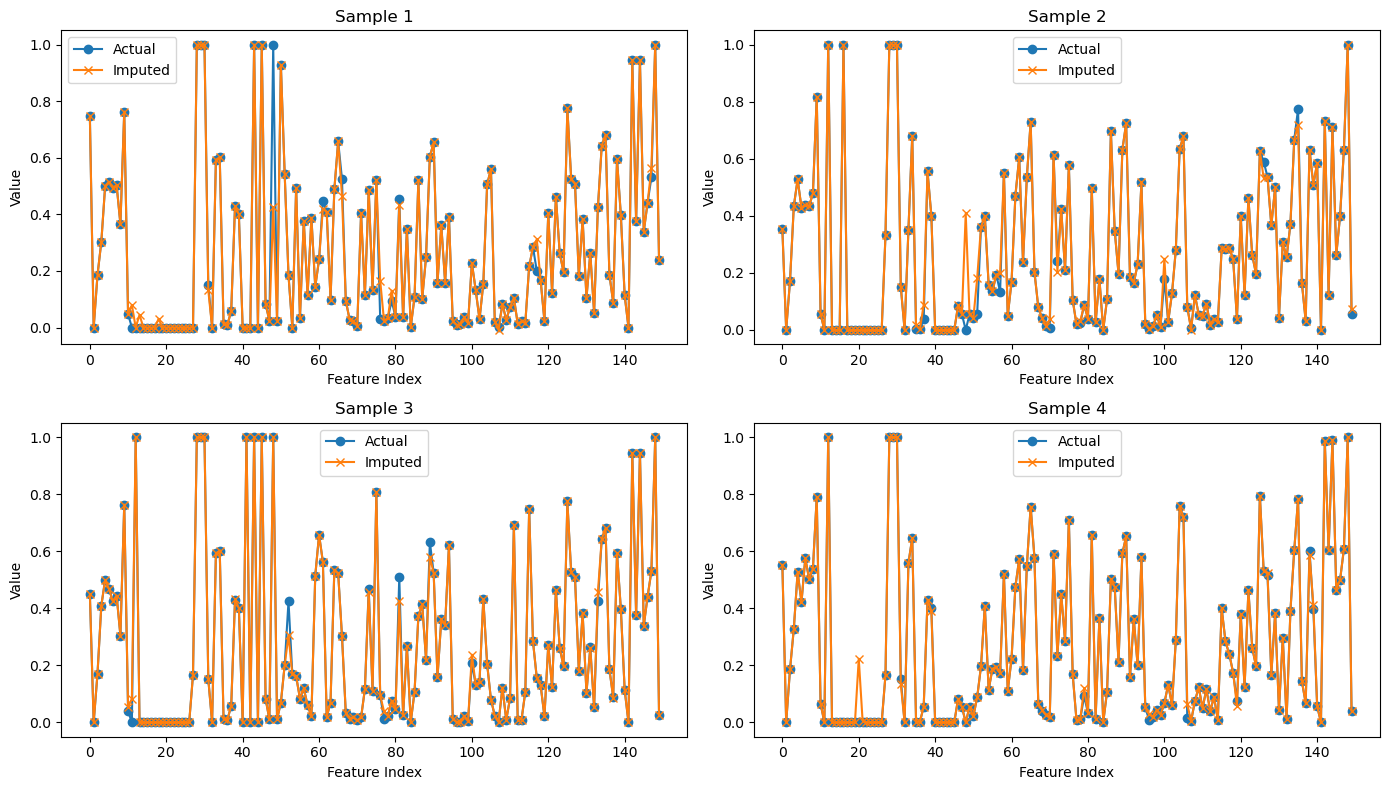

In [327]:
# Ensure num_samples_to_plot is within the range for creating subplots
num_samples_to_plot = 4  # Adjust this value based on your layout

# Visualize actual vs. imputed values for a few samples (features)
plt.figure(figsize=(14, 8))
for i in range(num_samples_to_plot):  # Adjust to ensure we don't exceed available subplots
    plt.subplot(2, (num_samples_to_plot + 1) // 2, i + 1)  # Create subplots dynamically
    plt.plot(test_data_np[i, 0, :], label='Actual', marker='o')  # Plot all features for sample i
    plt.plot(imputed_data[i, 0, :], label='Imputed', marker='x')  # Plot all features for sample i
    plt.title(f'Sample {i + 1}')
    plt.xlabel('Feature Index')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()

In [328]:
def calculate_rmse_for_imputed(imputed, actual, mask):
    imputed = imputed[mask]  # Use only the imputed values for positions that were missing
    actual = actual[mask]  # Use the actual values for positions that were missing
    return np.sqrt(((imputed - actual) ** 2).mean())

# Convert imputed and original test data to numpy arrays for RMSE calculation
imputed_data_np = imputed_data
test_data_np = test_data.cpu().numpy()
mask_np = mask.cpu().numpy()  # Mask indicating positions with missing values

# Calculate RMSE for the imputed values on MCAR data
rmse_imputed = calculate_rmse_for_imputed(imputed_data_np, test_data_np, mask_np)
print(f'RMSE for Imputed Values on MCAR Data: {rmse_imputed:.4f}')

RMSE for Imputed Values on MCAR Data: 0.1294


In [329]:
# Normalize RMSE using the range (max - min) of the actual data
data_range = np.max(test_data_np) - np.min(test_data_np)
nrmse_imputed = rmse_imputed / data_range  # Alternatively, use mean: rmse_imputed / np.mean(test_data_np)

print(f'RMSE for Imputed Values on MCAR Data: {rmse_imputed:.4f}')
print(f'NRMSE for Imputed Values on MCAR Data: {nrmse_imputed:.4f}')


RMSE for Imputed Values on MCAR Data: 0.1294
NRMSE for Imputed Values on MCAR Data: 0.1294
